In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_hdf('Data.h5')

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

decompose_hourly = []
decompose_daily = []
for i in range(data.shape[1]):
    series = data.iloc[:,i]
    decompose_hourly.append(seasonal_decompose(series, model='additive', freq=60).resid)
    decompose_daily.append(seasonal_decompose(series, model='additive', freq=60*24).resid)

In [24]:
df_daily = pd.DataFrame(decompose_daily).transpose().fillna(0)
df_hourly = pd.DataFrame(decompose_hourly).transpose().fillna(0)

In [83]:
window_size = 1000

rolling_means_daily = df_daily.rolling(window_size).mean()
rolling_stds_daily = df_daily.rolling(window_size).std()
anomalies_daily = rolling_stds_daily > rolling_stds_daily.mean() + rolling_stds_daily.std()

rolling_means_hourly = df_hourly.rolling(window_size).mean()
rolling_stds_hourly = df_hourly.rolling(window_size).std()
anomalies_hourly = rolling_stds_hourly > rolling_stds_hourly.mean() + rolling_stds_hourly.std()

In [122]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

107
610PDI008 DACA.PV


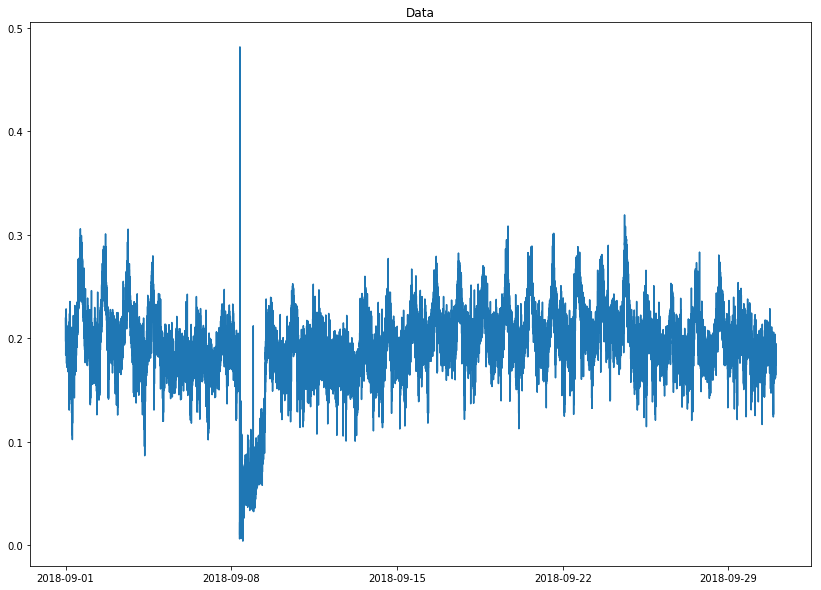

In [152]:
prev_steps = 100
i = np.random.randint(data.shape[1])
# i = 708
# i=202
# i=669
print(i)
print(data.columns[i])
plt.figure(figsize=(14,10))
plt.title('Data')
plt.plot(data.index, data.iloc[:,i])

X = []
y = []
for start in range(len(data.iloc[:,i][:-prev_steps])):
    tmp = data.iloc[:,i][start:start+prev_steps]
    tmp_resid_daily = df_daily.iloc[:,i][start:start+prev_steps]
    tmp_resid_hourly = df_hourly.iloc[:,i][start:start+prev_steps]
    X.append(np.array([tmp, tmp_resid_daily, tmp_resid_hourly]).reshape(-1,3))
    y.append(data.iloc[:,i][start+prev_steps])
X = np.array(X)
y = np.array(y)
# print(X.shape, X[0])
# print(y.shape, y[0])

In [153]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(prev_steps,3)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='mean_squared_logarithmic_error')

In [154]:
model.fit(X,y,epochs=10,batch_size=80)

Epoch 1/10
43100/43100 [==============================] - 35s 805us/step - loss: 0.0318
Epoch 2/10
43100/43100 [==============================] - 34s 792us/step - loss: 0.0318
Epoch 3/10
43100/43100 [==============================] - 34s 793us/step - loss: 0.0318
Epoch 4/10
43100/43100 [==============================] - 34s 795us/step - loss: 0.0318
Epoch 5/10
43100/43100 [==============================] - 34s 793us/step - loss: 0.0318
Epoch 6/10
43100/43100 [==============================] - 34s 795us/step - loss: 0.0318
Epoch 7/10
43100/43100 [==============================] - 34s 796us/step - loss: 0.0318
Epoch 8/10
43100/43100 [==============================] - 34s 798us/step - loss: 0.0318
Epoch 9/10
43100/43100 [==============================] - 34s 800us/step - loss: 0.0318
Epoch 10/10
43100/43100 [==============================] - 35s 801us/step - loss: 0.0318


In [155]:
preds = model.predict(X)
errors = preds.reshape(-1) - y

In [156]:
error_df = pd.DataFrame(errors)

rolling_means_error = error_df.rolling(window_size).mean()
rolling_stds_error = error_df.rolling(window_size).std()

anomalies_rolling = rolling_stds_error > rolling_stds_error.mean() + 1.5 * rolling_stds_error.std()

In [157]:
anomalies = errors > errors.mean() + 2 * errors.std()

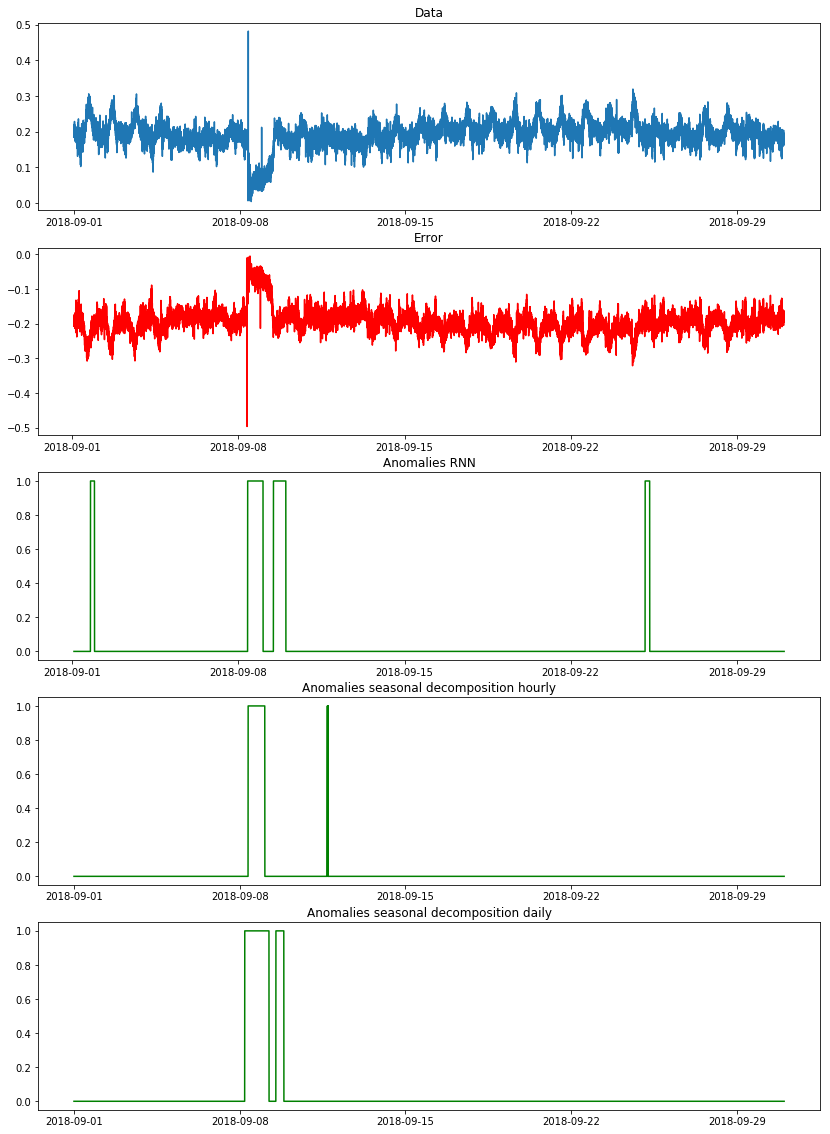

In [159]:
plt.figure(figsize=(14,20))
plt.subplot(5,1,1)
plt.title('Data')
plt.plot(data.index, data.iloc[:,i])

plt.subplot(5,1,2)
plt.title('Error')
plt.plot(data.index[prev_steps:], errors, color='red')

# plt.subplot(6,1,3)
# plt.title('Anomalies RNN')
# plt.plot(data.index[prev_steps:], anomalies, color='green')

plt.subplot(5,1,3)
plt.title('Anomalies RNN')
plt.plot(data.index[prev_steps:], anomalies_rolling, color='green')

plt.subplot(5,1,4)
plt.title('Anomalies seasonal decomposition hourly')
plt.plot(data.index, anomalies_hourly.iloc[:,i], color='green')

plt.subplot(5,1,5)
plt.title('Anomalies seasonal decomposition daily')
plt.plot(data.index, anomalies_daily.iloc[:,i], color='green')

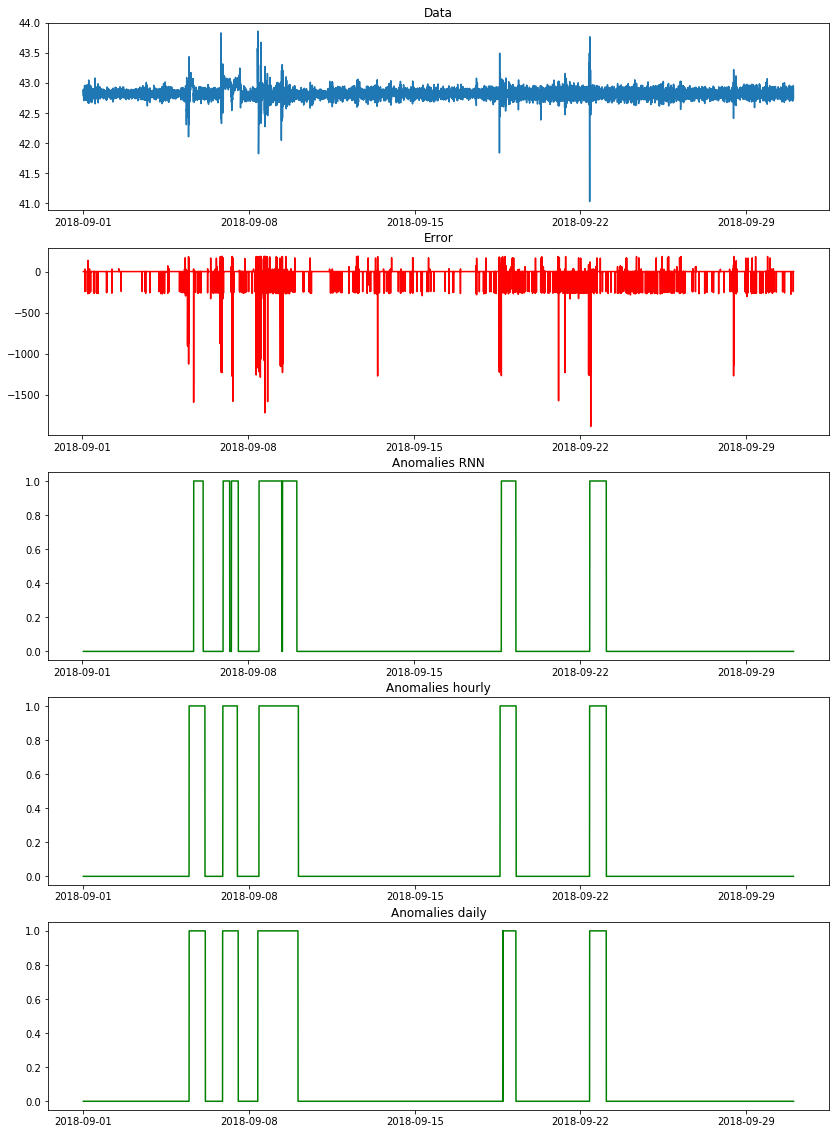

In [119]:
plt.figure(figsize=(14,20))
plt.subplot(5,1,1)
plt.title('Data')
plt.plot(data.index, data.iloc[:,i])

plt.subplot(5,1,2)
plt.title('Error')
plt.plot(data.index[prev_steps:], errors, color='red')

# plt.subplot(6,1,3)
# plt.title('Anomalies RNN')
# plt.plot(data.index[prev_steps:], anomalies, color='green')

plt.subplot(5,1,3)
plt.title('Anomalies RNN')
plt.plot(data.index[prev_steps:], anomalies_rolling, color='green')

plt.subplot(5,1,4)
plt.title('Anomalies hourly')
plt.plot(data.index, anomalies_hourly.iloc[:,i], color='green')

plt.subplot(5,1,5)
plt.title('Anomalies daily')
plt.plot(data.index, anomalies_daily.iloc[:,i], color='green')